In [20]:
import geopandas
import contextily as cx
import numpy as np
import os
import pickle
from shapely import geometry, speedups
import matplotlib.pyplot as plt

#### Variables

In [21]:
# These Data should be fetched from a csv, given a city name or something
path = 'microsoft_buildings/'
city = 'Cairo'
population =  21766883 # census 2021 data for 'Greater Cairo'
resolution = 500
# From your slides -- in EPSG 3857
total_bounds = (3432312.15605818, 3472649.85036615, 3542328.20802579, 3557341.34861715)

##### Grid Class

In [52]:
## Produces a shapely POLYGON grid over a given area with a given meter resolution.

class Grid:
    def __init__(self, city, total_bounds, resolution, population):
        self.city = city
        self.population = population
        self.building_list = []
        self.buildings = 0
        self.grid = geopandas.GeoDataFrame()
        # Expected Pixel Resolution
        self.length = resolution
        self.xmin, self.ymin, self.xmax, self.ymax = total_bounds
      
    
    def saveGrid(self, filename):
        with open(filename, 'wb') as output:
            pickle.dump(self, output)
        return
        
    def loadGrid(self, filename):
        with open(filename, 'rb') as loaded_file:
            loaded_class = pickle.load(loaded_file)
            self.city = loaded_class.city
            self.population = loaded_class.population
            self.grid = loaded_class.grid
            self.length = loaded_class.length
            self.xmin = loaded_class.xmin
            self.ymin = loaded_class.ymin
            self.xmax = loaded_class.xmax
            self.ymax = loaded_class.ymax
        return
        
          
    def createGrid(self):
        x, y = (self.xmin, self.ymin)
        array = []
        while y <= self.ymax:
            while x <= self.xmax:
                poly = geometry.Polygon([
                    (x,y), (x, y+self.length), 
                    (x+self.length, y+self.length), 
                    (x+self.length, y), (x, y)
                ])
                array.append([poly, 0])
                x += self.length
            x = self.xmin
            y += self.length
        grid = geopandas.GeoDataFrame(array, columns=['geometry', 'population']).set_crs('EPSG:3857')
        self.grid = grid.to_crs('EPSG:4326')
        self.grid["ID"] = np.arange(len(self.grid))
        return

            
    def fetchBuildings(self):
        return geopandas.read_file(path+city+'.json')

    
    def setBuildings(self):
        # Set number of building per grid cell
        speedups.enable()
        df = self.fetchBuildings()
        self.buildings += df.size
        buildings_in_cells = geopandas.sjoin(df, self.grid, how='inner', predicate='within')
        buildings_in_cells['n_buildings']=1
        buildings_in_cells = buildings_in_cells.groupby('ID').agg({'n_buildings':'sum'})
        self.grid = self.grid.merge(buildings_in_cells, on = 'ID', how = "left")
        self.grid['n_buildings'] = self.grid['n_buildings'].fillna(0)
        return
    
    
    def setPopulationV1(self):
        # Evenly distributes the population on the grid
        self.grid['population'] = self.population / self.grid.size
        return
    
    
    def setPopulationV2(self):
        # Distributes population given the building density
        self.grid['population'] = self.population * self.grid['n_buildings'] / self.buildings
        return
        
        
    def plotPopulation(self):
        # Plots population density for now 
        ax = self.grid.plot(column='population', figsize=(15, 10), cmap='terrain', alpha=0.5, legend=True)
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=self.grid.crs)
        
    

##### Tests

Declaration, creations, save and load

In [53]:
grid = Grid(city, total_bounds, resolution, population)

In [54]:
grid.createGrid()
grid.grid.head()

,geometry,population,ID
0,"POLYGON ((30.83298 29.75932, 30.83298 29.76322...",0,0
1,"POLYGON ((30.83748 29.75932, 30.83748 29.76322...",0,1
2,"POLYGON ((30.84197 29.75932, 30.84197 29.76322...",0,2
3,"POLYGON ((30.84646 29.75932, 30.84646 29.76322...",0,3
4,"POLYGON ((30.85095 29.75932, 30.85095 29.76322...",0,4


In [55]:
grid.saveGrid('cairo.pickl')

V1

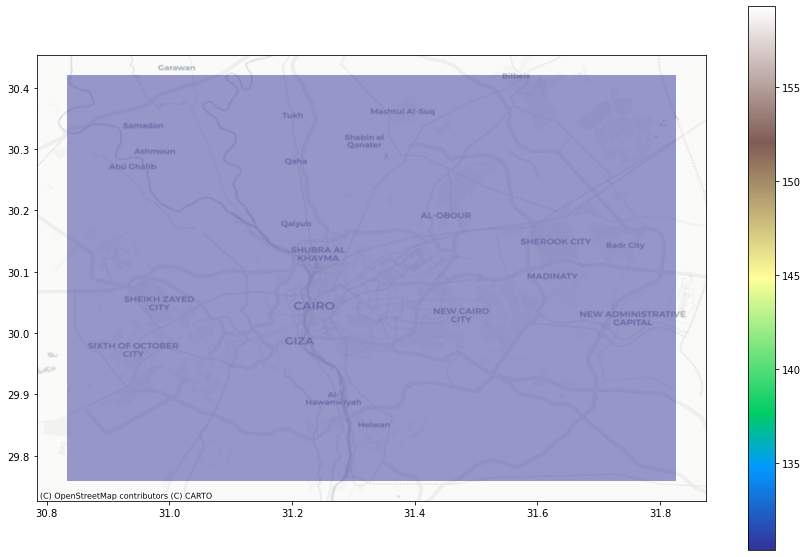

In [59]:
grid.setPopulationV1()
grid.plotPopulation()

V2

In [56]:
grid.setBuildings()

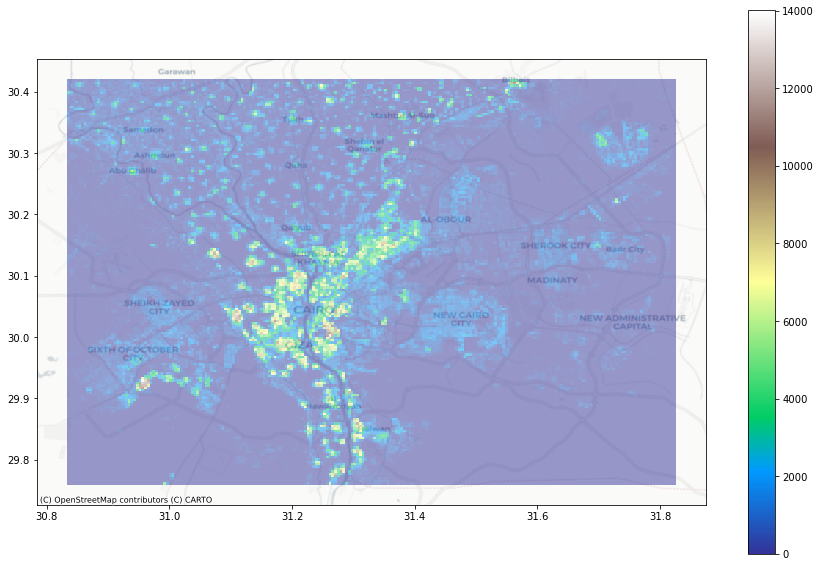

In [62]:
grid.setPopulationV2()
grid.plotPopulation()

#### Comments
_We can see that New Cairo has a relatively low (population * building) density,  
although it certainly has more recent - ie. higher - buildings, indirectly emitting more CO2_

In [61]:
grid.saveGrid('cairo.pickl')